# 作業 : (Kaggle)鐵達尼生存預測
***
https://www.kaggle.com/c/titanic

# [作業目標]
- 試著模仿範例寫法, 在鐵達尼生存預測中, 觀察計數編碼與特徵雜湊的效果

# [作業重點]
- 仿造範例, 完成自己挑選特徵的群聚編碼 (In[2], Out[2])
- 觀察群聚編碼, 搭配邏輯斯回歸, 看看有什麼影響 (In[5], Out[5], In[6], Out[6]) 

# 參考資料
- [利用 Python 數據分析之數據聚合與分組](https://zhuanlan.zhihu.com/p/27590154)
> 這份網頁雖然談的也都是群聚編碼，不過卻包含相當多種組合的方式，更重要的，是包含了許多的聚類編碼程式範例，很適合在同學自己使用聚類編碼時參考。![image.png](https://ai100-fileentity.cupoy.com/2nd/homework/D27/1557733747226/large)

# 作業1
* 試著使用鐵達尼號的例子，創立兩種以上的群聚編碼特徵( mean、median、mode、max、min、count 均可 )

In [1]:
# 做完特徵工程前的所有準備 (與前範例相同)
import pandas as pd
import numpy as np
import copy
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

data_path = 'data/part2/'
df = pd.read_csv(data_path + 'titanic_train.csv')

train_Y = df['Survived']
df = df.drop(['PassengerId', 'Survived'] , axis=1)
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### 挑Ticket & Fare 欄位來做群聚編碼

Ticket缺失值數目: 0
Fare缺失值數目: 0


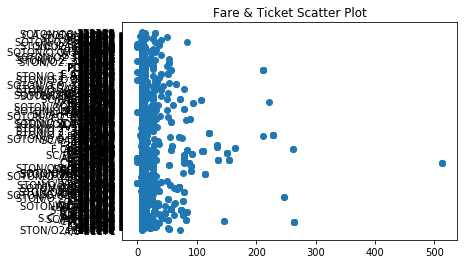

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

print('Ticket缺失值數目:', df[df['Ticket'].isnull()].shape[0])
print('Fare缺失值數目:', df[df['Fare'].isnull()].shape[0])

plt.scatter(df['Fare'], df['Ticket'])
plt.title("Fare & Ticket Scatter Plot")
plt.show()

In [3]:
# 取一個類別型欄位, 與一個數值型欄位, 做群聚編碼
"""
Your Code Here
"""
df['Ticket'] = df['Ticket'].fillna('None')
df['Fare'] = df['Fare'].fillna(df['Fare'].median())
mean_df = df.groupby(['Ticket'])['Fare'].mean().reset_index()
mode_df = df.groupby(['Ticket'])['Fare'].apply(lambda x: x.mode()[0]).reset_index()
median_df = df.groupby(['Ticket'])['Fare'].median().reset_index()
max_df = df.groupby(['Ticket'])['Fare'].max().reset_index()
min_df = df.groupby(['Ticket'])['Fare'].min().reset_index()
count_df = df.groupby(['Ticket'])['Fare'].count().reset_index()
temp = pd.merge(mean_df, mode_df, how='left', on=['Ticket'])
temp = pd.merge(temp, median_df, how='left', on=['Ticket'])
temp = pd.merge(temp, max_df, how='left', on=['Ticket'])
temp = pd.merge(temp, min_df, how='left', on=['Ticket'])
temp = pd.merge(temp, count_df, how='left', on=['Ticket'])
temp.columns = ['Ticket', 'Fare_Mean', 'Fare_Mode', 'Fare_Median', 'Fare_Max', 'Fare_Min', 'Fare_Count']
df = pd.merge(df, temp, how='left', on=['Ticket'])
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Fare_Mean,Fare_Mode,Fare_Median,Fare_Max,Fare_Min,Fare_Count
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,7.2500,7.2500,7.2500,7.2500,7.2500,1
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,71.2833,71.2833,71.2833,71.2833,71.2833,1
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,7.9250,7.9250,7.9250,7.9250,7.9250,1
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,53.1000,53.1000,53.1000,53.1000,53.1000,2
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,8.0500,8.0500,8.0500,8.0500,8.0500,1


In [4]:
#只取 int64, float64 兩種數值型欄位, 存於 num_features 中
num_features = []
for dtype, feature in zip(df.dtypes, df.columns):
    if dtype == 'float64' or dtype == 'int64':
        num_features.append(feature)
print(f'{len(num_features)} Numeric Features : {num_features}\n')

# 削減文字型欄位, 只剩數值型欄位
df = df[num_features]
df = df.fillna(-1)
MMEncoder = MinMaxScaler()
df.head()

11 Numeric Features : ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Fare_Mean', 'Fare_Mode', 'Fare_Median', 'Fare_Max', 'Fare_Min', 'Fare_Count']



,Pclass,Age,SibSp,Parch,Fare,Fare_Mean,Fare_Mode,Fare_Median,Fare_Max,Fare_Min,Fare_Count
0,3,22.0,1,0,7.2500,7.2500,7.2500,7.2500,7.2500,7.2500,1
1,1,38.0,1,0,71.2833,71.2833,71.2833,71.2833,71.2833,71.2833,1
2,3,26.0,0,0,7.9250,7.9250,7.9250,7.9250,7.9250,7.9250,1
3,1,35.0,1,0,53.1000,53.1000,53.1000,53.1000,53.1000,53.1000,2
4,3,35.0,0,0,8.0500,8.0500,8.0500,8.0500,8.0500,8.0500,1


# 作業2
* 將上述的新特徵，合併原有的欄位做生存率預估，結果是否有改善?
> 沒有，反而變差了一點，可能是特徵選不好，或者是作群聚編碼時選擇的特徵不好

In [5]:
# 原始特徵 + 邏輯斯迴歸
"""
Your Code Here
"""
df_minus = df.drop(['Fare_Mean', 'Fare_Mode', 'Fare_Median', 'Fare_Max', 'Fare_Min', 'Fare_Count'], axis=1)

train_X = MMEncoder.fit_transform(df_minus)
estimator = LogisticRegression(solver='liblinear')
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

C:\Users\StayFoolish\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


0.7038635542329971

In [6]:
# 新特徵 + 邏輯斯迴歸
"""
Your Code Here
"""
df_test = df.drop(['Fare_Mean', 'Fare_Mode', 'Fare_Median', 'Fare_Max', 'Fare_Min', 'Fare_Count'], axis=1)
train_X = MMEncoder.fit_transform(df)
estimator = LogisticRegression(solver='liblinear')
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

C:\Users\StayFoolish\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


0.7016289882888318

In [7]:
from sklearn.ensemble import GradientBoostingRegressor
train_X = MMEncoder.fit_transform(df_minus)
estimator = GradientBoostingRegressor()
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

C:\Users\StayFoolish\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


0.1816292966023218

In [8]:
from sklearn.ensemble import GradientBoostingRegressor
train_X = MMEncoder.fit_transform(df)
estimator = GradientBoostingRegressor()
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

C:\Users\StayFoolish\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


0.17962995772652746

In [9]:
from sklearn.linear_model import LinearRegression
train_X = MMEncoder.fit_transform(df_minus)
estimator = LinearRegression()
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

C:\Users\StayFoolish\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


0.11619613893016796

In [10]:
train_X = MMEncoder.fit_transform(df)
estimator = LinearRegression()
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

C:\Users\StayFoolish\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


0.11676749163548632

# 解答取船票票號(Ticket), 對乘客年齡(Age)做群聚編碼
結果可以發現 : 不論是例題的線性迴歸或者梯度提升樹, 以及作業的邏輯斯迴歸
聚類編碼都在正確率上有穩定提升, 這就是我們所說的:均值編碼容易overfitting/聚類編碼不容易overfitting的效果
不過助教這邊的數值型特徵與類別型特徵, 是有特別用特徵重要性挑選過的, 因此同學自行挑選的特徵可能未必提升
至於特徵重要性如何使用, 請同學參考 Day29 內容